In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns  # >= 0.9
import sqlite3
sns.set(context='talk', style='whitegrid', color_codes=True)

In [2]:
mpl.rcParams['figure.figsize'] = (10,6)

# Preamble



Type Ia supernovae (SNe Ia) are generally thought to be the thermonuclear disruption of a carbon-oxygen white-dwarf star (WD) in a binary system (see, e.g., Hillebrandt & Niemeyer 2000 for a review), but their formation scenarios and exact progenitor systems are still ambiguous. The photospheric velocity of SNe Ia measured from the strong Si II λ6355 absorption line in their spectrum (e.g., Silverman et al. 2012) at the time of peak brightness is an important parameter for studying the various properties of SNe Ia. The ejecta velocity distribution is also a possible clue for revealing asymmetries in SN Ia explosions. Recent studies reveal that the distribution of SN Ia velocity does not originate from a uniform class. [Wang, X. et al. (2013)](https://arxiv.org/abs/1303.2601) and [Zheng et al. (2018)](https://arxiv.org/abs/1712.01495) show that there exists a subclass of SNe Ia with high velocities (Figures 1 and 2), indicating a different origin for some SNe Ia.

Asymmetric SN Ia explosions could cause different measured ejecta velocities observed from different lines of sight. We intend to model the ejecta velocity of SNe Ia seen from different lines of sight through numerical simulations to test if the simulated velocity distribution could match the observed velocity distribution. We expect the model to demonstrate properties of velocity, ejecta size, and rarity of the high-velocity ejecta compared to the low-velocity. The results of the simulations will be a random sample of the velocity distribution to be compared with the real data.

Due to the limited time alloted for this project, a few descoping option was used. The original method of parameter estimation was MCMC which the posterior of the parameters were difficult to interpret. Further convergence test was needed therefore I decided MCMC was too time consuming. Parameter estimation was descoped form MCMC to grid search which provides a single set of best estimated parameters instead of a posterior. A quality slice in Si II velocity was also made to descope so that the methods matches those in Wang, X. et al. (2013) easily. Finally, the last descope made as assuming that all SNe Ia have high-velocity ejecta instead of using a prior.


# The Data

The dataset composed of data coming from two papers.

## Wang, X. et al (2013)

The dataset was extracted from [Wang, X. et al (2013) supplementary materials](https://science.sciencemag.org/content/340/6129/170/tab-figures-data) which consist of data from the Lick Observatory Supernovae Search (LOSS, [Leaman et al. 2011](https://academic.oup.com/mnras/article/412/3/1419/1049104)). A quality cut in Si II velocity was made to only include velocities between $0.7$ to $1.8$ ($10^4$ $\text{km/s}$). There exist an error column for Si II velocity however was ignored as the errors were suspiciously all integers. Further inquiry from the original author or the original observers (Lick Observatory Supernovae Search) is required to interpret the errors.

In [3]:
def import_sn_data(fpath='sn_data.txt'):
    df = pd.read_csv(fpath, sep='\s+', index_col=0, na_values=['...', 'NaN'])
    df = clean_sn_data(df)
    return df
    
    
def clean_sn_data(df):
    df = (df
          .iloc[:,[9,10]]
          .loc[~df['v_siII'].isnull(), :]
          .loc[(df['v_siII'] > 0.7) & (df['v_siII'] < 1.8)]
         )
    df['v_siII'] = df['v_siII'] * 10 # change to units of 10^3 km/s
    return df

sn_data = import_sn_data()
display(sn_data.head())
display(sn_data.info(verbose=True))
display(sn_data.describe())

,v_siII,v_siII_err
SN,,
1998de,11.3,2.0
1998dk,12.7,3.0
1998ef,13.3,2.0
1998es,11.8,2.0
1999aa,10.4,2.0


<class 'pandas.core.frame.DataFrame'>
Index: 153 entries, 1998de to 2008hv
Data columns (total 2 columns):
v_siII        153 non-null float64
v_siII_err    153 non-null float64
dtypes: float64(2)
memory usage: 3.6+ KB


None

,v_siII,v_siII_err
count,153.000000,153.000000
mean,11.414379,3.686275
std,1.500281,2.021173
min,8.100000,2.000000
25%,10.400000,2.000000
50%,11.000000,3.000000
75%,12.100000,5.000000
max,16.000000,10.000000


Here, the right histogram plotted in Figure 1 from Wang, X. et al. (2013), is replotted below

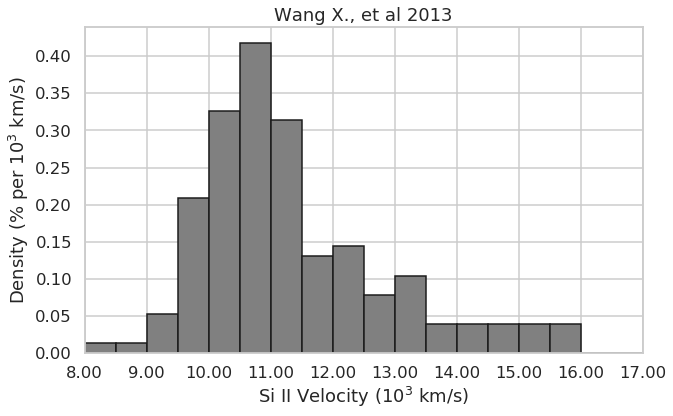

In [4]:
from scipy.optimize import curve_fit
from models import bimodal_gaussian, gaussian

x = sn_data['v_siII']
bins = np.arange(0.8, 1.75, 0.05) * 10
plt.hist(x, density=True, bins=bins, color='gray', fill=True, edgecolor='k', joinstyle='miter', label='Observed');

plt.xticks(bins[::2], [f'{tick:.2f}' for tick in bins[::2]])
plt.xlim(bins.min(), bins.max())
plt.xlabel('Si II Velocity ($10^3$ km/s)')
plt.ylabel('Density (% per $10^3$ km/s)')
plt.title('Wang X., et al 2013');

## Kaepora

The dataset comes from the kaepora database ([Siebert, M. R. et al. 2019](https://academic.oup.com/mnras/article/486/4/5785/5484870))

In [5]:
con = sqlite3.connect('kaepora_v1.db')
query = "SELECT * FROM Events;"
kaepora = pd.read_sql(query, con).set_index('SN')
col_slc = [
#     'RA', 'DEC', 'M_b_cfa', 'M_b_cfa_err', 'Bmag_salt', 'e_Bmag_salt', 'Bmag_salt2', 'e_Bmag_salt2', 
    'V_at_max', 'V_err'
]
colname = [
#     'RA', 'Dec', 'Bmag_CFA', 'Bmag_CFA_err', 'Bmag_SALT', 'Bmag_SALT_err', 'Bmag_SALT2', 'Bmag_SALT2_err', 
    'v_siII', 'v_siII_err'
]
kaepora = kaepora[col_slc].rename({old: new for old, new in zip(col_slc, colname)}, axis=1)
kaepora = kaepora.loc[kaepora['v_siII'].notna()]
kaepora['v_siII'] = -kaepora['v_siII']
kaepora.head()

,v_siII,v_siII_err
SN,,
2006td,10.81260,0.300000
1996z,12.14210,0.233568
1996x,11.17310,0.222453
1996c,10.68910,0.222453
2005m,8.09394,0.231052


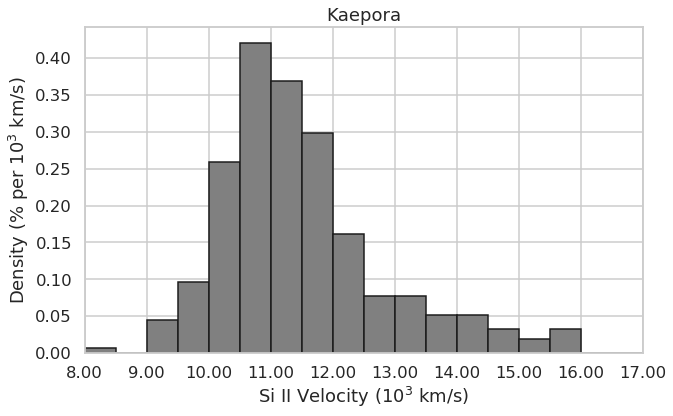

In [6]:
x = kaepora['v_siII']
bins = np.arange(8, 17.5, 0.5)
plt.hist(x, density=True, bins=bins, color='gray', fill=True, edgecolor='k', joinstyle='miter', label='Observed')

plt.xticks(bins[::2], [f'{tick:.2f}' for tick in bins[::2]])
plt.xlim(bins.min(), bins.max())
plt.xlabel('Si II Velocity ($10^3$ km/s)')
plt.ylabel('Density (% per $10^3$ km/s)')
plt.title('Kaepora');

In [7]:
sn_data.head()

,v_siII,v_siII_err
SN,,
1998de,11.3,2.0
1998dk,12.7,3.0
1998ef,13.3,2.0
1998es,11.8,2.0
1999aa,10.4,2.0


In [8]:
kaepora.head()

,v_siII,v_siII_err
SN,,
2006td,10.81260,0.300000
1996z,12.14210,0.233568
1996x,11.17310,0.222453
1996c,10.68910,0.222453
2005m,8.09394,0.231052


In [9]:
sn_data.loc['2001eh',:]

v_siII        10.7
v_siII_err     2.0
Name: 2001eh, dtype: float64

In [10]:
sn_data.duplicated()

SN
1998de    False
1998dk    False
1998ef    False
1998es    False
1999aa    False
1999ac    False
1999bh    False
1999by    False
1999cl    False
1999cp    False
1999da    False
1999dk    False
1999dq    False
1999ej    False
1999ek     True
2000A     False
2000B     False
2000cn    False
2000dg    False
2000dn    False
2000dr    False
2000dx    False
2001ay    False
2001br     True
2001bs    False
2001cj    False
2001de    False
2001E     False
2001eh     True
2001ep    False
          ...  
2007ax     True
2007ba     True
2007bc     True
2007bd    False
2007bm     True
2007cc     True
2007cf    False
2007ci    False
2007cp     True
2007fb     True
2007fc    False
2007gi    False
2007hu    False
2007ir    False
2007is     True
2007kk    False
2007oo     True
2008R     False
2008bi    False
2008dr    False
2008dt    False
2008ec    False
2008ep     True
2008fj     True
2008gg    False
2008gl    False
2008gp    False
2008hj    False
2008hs    False
2008hv    False
Length: 153, dtype: b

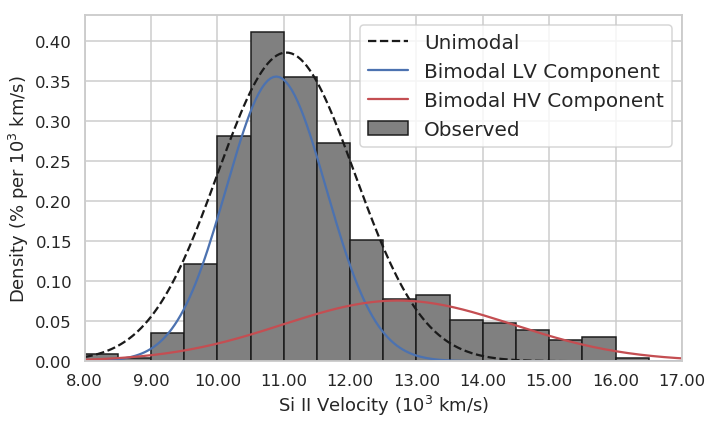

In [11]:
from dataloader import import_all_data
from scipy.optimize import curve_fit

sn_data = import_all_data()

x = sn_data['v_siII']
bins = np.arange(8, 17.5, 0.5)
plt.hist(x, density=True, bins=bins, color='gray', fill=True, edgecolor='k', joinstyle='miter', label='Observed')

# Unimodal Gaussian
xrange = np.linspace(bins.min(), bins.max(), 200)
ydata, xdata = np.histogram(x, bins=np.arange(0.8, 1.75, 0.1) * 10, density=True)
xdata = (xdata[:-1] + xdata[1:]) / 2
opt, cov = curve_fit(gaussian, xdata, ydata, p0=[np.mean(x), np.std(x)])
plt.plot(xrange, gaussian(xrange, *opt), '--', color='k', label='Unimodal')

# Bimodal Gaussian
opt, cov = curve_fit(bimodal_gaussian, xdata, ydata, p0=[11, 1, 15, 1, 0.5])
# plt.plot(xrange, bimodal_gaussian(xrange, *opt), color='gray', label='Bimodal')
plt.plot(xrange, opt[4]*gaussian(xrange, *opt[0:2]), 'b', label='Bimodal LV Component')
plt.plot(xrange, (1-opt[4])*gaussian(xrange, *opt[2:4]), 'r', label='Bimodal HV Component')

# Plot config
plt.xticks(bins[::2], [f'{tick:.2f}' for tick in bins[::2]])
plt.xlim(bins.min(), bins.max())
plt.legend(fontsize=20)
plt.xlabel('Si II Velocity ($10^3$ km/s)')
plt.ylabel('Density (% per $10^3$ km/s)')

# Save results
plt.tight_layout()
plt.savefig('velocity_dist.png', orientation='landscape', format='png', dpi=600)
np.savetxt('bimodal_params.csv', opt, delimiter=',')

# Method

Assumptions:
    
* Velocity of the Si II in the photosphere is egg shaped inspired by the result of [Kasen and Plewa 2007](https://ui.adsabs.harvard.edu/abs/2007ApJ...662..459K/abstract) with three velocities located at three different angular position of interest:

    $$
    v_\mathrm{H} = v(\theta=0)\\
    v_\mathrm{L} = v(\theta=\pi/2)\\
    v_\mathrm{M} = v(\theta=\pi)\\
    v_H > v_M > v_L
    $$
    
* Axis of symmetry intersecting $\theta=0$ and $\theta=\pi$
* Velocity as a function of viewing angle $\theta$ is given by:

    $$
    v(\theta) = 
    \begin{cases}
    v_L - \left(\frac{v_H - v_L}{\pi/2}\right)\left(\theta - \frac{\pi}{2} \right) & 0 \le \theta \le \frac{\pi}{2}\\
    v_L + \left(\frac{v_M - v_L}{\pi/2}\right)\left(\theta - \frac{\pi}{2} \right) & \pi/2 \le \theta \le \pi
    \end{cases}
    $$
    
    The mirror opposite is true for $-\pi \le  \theta \le 0$
    
* We consider two parameters $v_H - v_L$ from here on denoted as the range of the velocity $\Delta v$ and the ratio of the velocity differences $R$:

$$
R = \frac{v_H - v_L}{v_M-v_L} = \text{const}\\
R > 1
$$

* From the SNe Ia data, $v_L$ will be sampled from the low velocity Gaussian distribution.

## Parameter Estimation - Grid Search

Using the simulation above, the best estimated parameters is determined by a grid search amongst all two parameters. The range of the grid is given below. The interval syntax is range(low, high, step):

$$
\begin{align}
\Delta v &\in \text{range}(10,~ 40,~ 10) \quad [10^3~\text{km/s}]\\
R  &\in \text{range}(4/3,~ 9/3,~ 1/3)\\
\end{align}
$$

In total, $N$ sets of parameters were simulated. Each simulation was scored by the Kolmogorov-Smirov (KS) test.

In [20]:
import pickle as pkl

with open('scores.pkl', 'rb') as f:
    scores = pkl.load(f)

pvalues = scores['pvalue']
sort_idx = np.argsort(pvalues)[::-1]

pvalues = pvalues[sort_idx]
lv_samp = scores['lv_samp'][sort_idx]
hvs = scores['hvs'][sort_idx]
ks = scores['ks'][sort_idx]
params = scores['params']

# nrows, ncols = 6, 4
# fig, axs = plt.subplots(nrows, ncols, figsize=(16, 4.5*nrows))

# for i in range(nrows*ncols):
#     best_hvs = hvs[i]
#     best_params = params[i]
#     R, delta_v = best_params['R'], best_params['delta_v']
    
#     ax = axs[i//ncols, i%ncols]
#     bins = np.arange(8, 17.5, 0.5)
#     ax.hist(sn_data['v_siII'], bins, density=True, alpha=0.5, label='Data')
#     ax.hist(hvs[i], bins, density=True, alpha=0.5)

# plt.tight_layout()

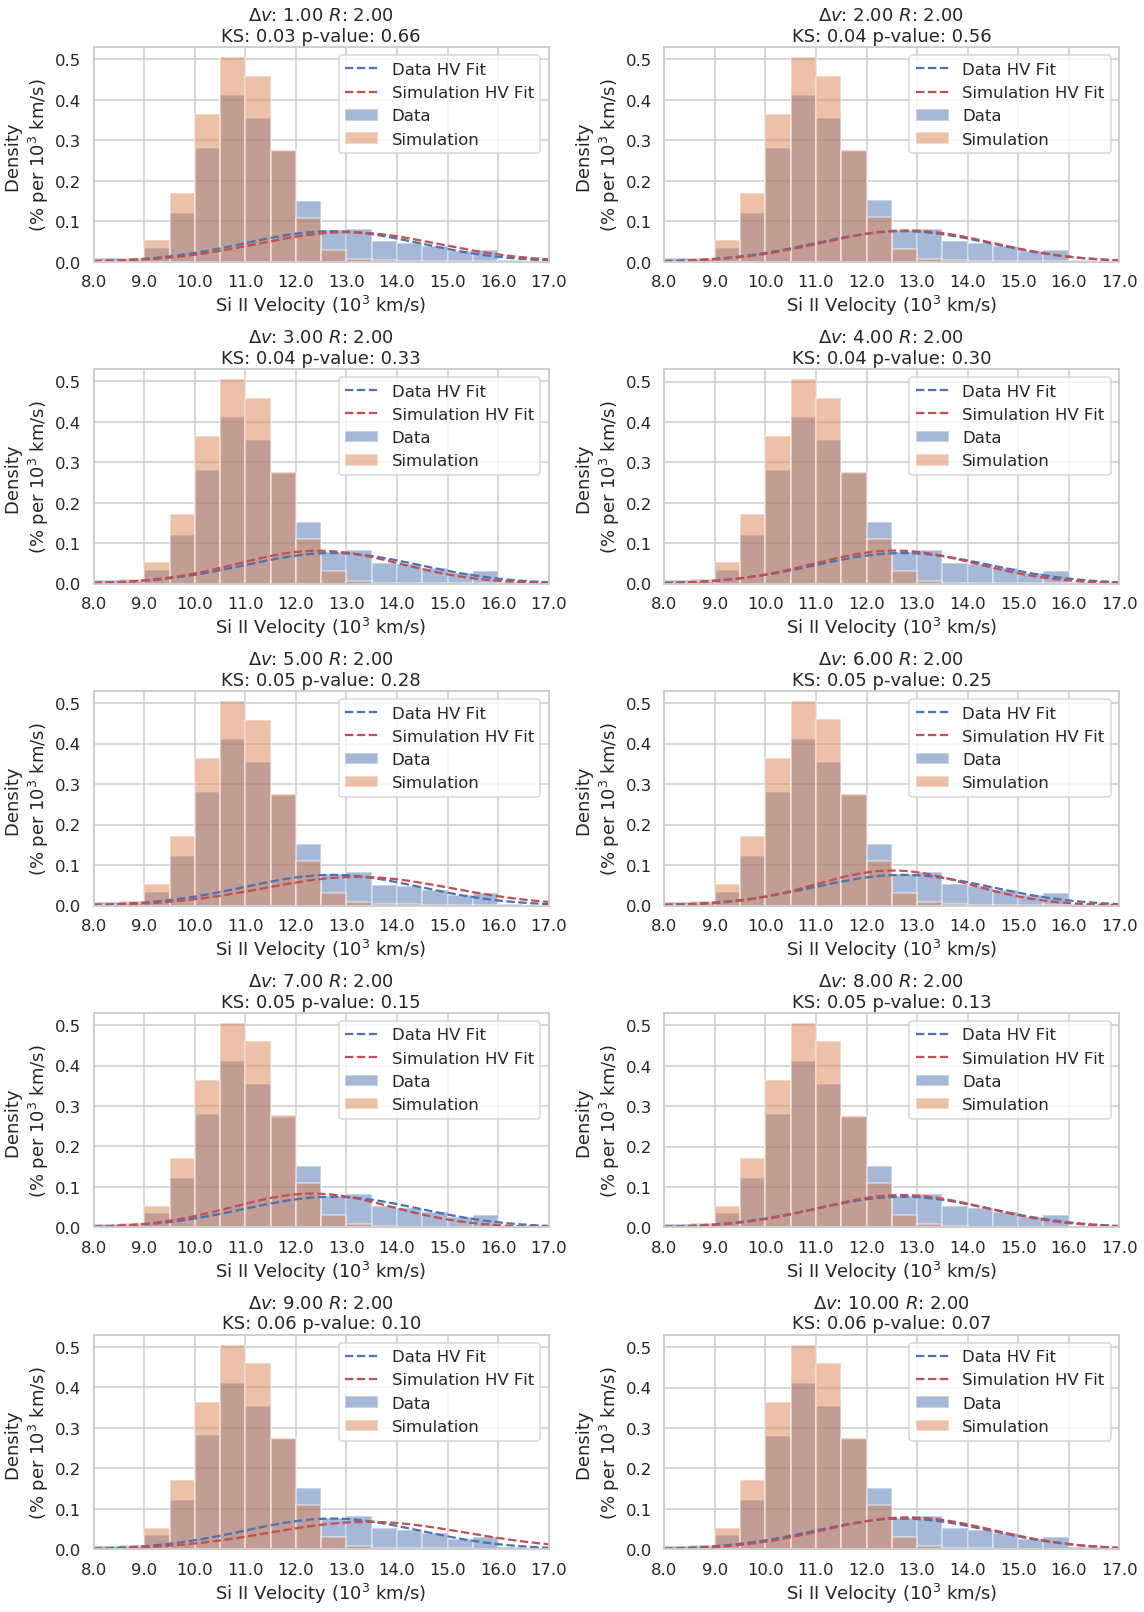

In [21]:
from scipy.stats import kstest, norm, ks_2samp

nrows, ncols = 5, 2
fig, axs = plt.subplots(nrows, ncols, figsize=(16, 4.5*nrows))


for i in range(nrows*ncols):
    ax = axs[i//ncols, i%ncols]
    bins = np.arange(8, 17.5, 0.5)
    xrange = np.linspace(bins.min(), bins.max(), 200)
    
    bimodal_params = np.loadtxt('bimodal_params.csv', delimiter=',')
    lv_params = bimodal_params[:2]
    hv_params = bimodal_params[2:-1]
    mixing_param = bimodal_params[-1]
    param = params[i]
    
    
    # Data
    ax.hist(sn_data['v_siII'], bins, density=True, alpha=0.5, label='Data')
    
    # LV Component
#     ax.plot(xrange, gaussian(xrange, *lv_params) * mixing_param, '--k')
    
    # HV Component Data Fit
    ax.plot(xrange, gaussian(xrange, *hv_params) * (1-mixing_param), '--b', label="Data HV Fit")
    
    # HV Simulation
    # Use HV from simulation and LV from sampling data fit
    hv_samp = hvs[i]
    
#     lv_pdf = norm(*bimodal_params[:2])
#     lv_size = int(len(hv_samp) / (1-mixing_param))
#     lv_samp = lv_pdf.rvs(size=lv_size)
    
    ax.hist(np.append(hv_samp, lv_samp), bins, density=True, alpha=0.5, label="Simulation")
    
    # HV Component Simulation Fit
    # Gaussian fit on the simulation
    ydata, xdata = np.histogram(hv_samp, bins=np.arange(0.8, 1.75, 0.1) * 10, density=True)
    xdata = (xdata[:-1] + xdata[1:]) / 2
    opt, cov = curve_fit(gaussian, xdata, ydata, p0=[np.mean(hv_samp), np.std(hv_samp)])
    ax.plot(xrange, gaussian(xrange, *opt) * (1-mixing_param), '--r', label="Simulation HV Fit")

    
    # Plot Config
    ax.set_xlabel('Si II Velocity ($10^3$ km/s)')
    ax.set_ylabel('Density \n(% per $10^3$ km/s)')
    ax.set_title(f"$\Delta v$: {param['delta_v']:.2f} $R$: {param['R']:.2f} \nKS: {ks[i]:.2f} p-value: {pvalues[i]:.2f}")
    ax.set_xticks(bins[::2])
    ax.set_xticklabels([f'{tick:.1f}' for tick in bins[::2]])
    ax.set_xlim(bins.min(), bins.max())
    ax.legend()
    
plt.tight_layout()
plt.savefig('grid_search_results.png', dpi=300, format='png')

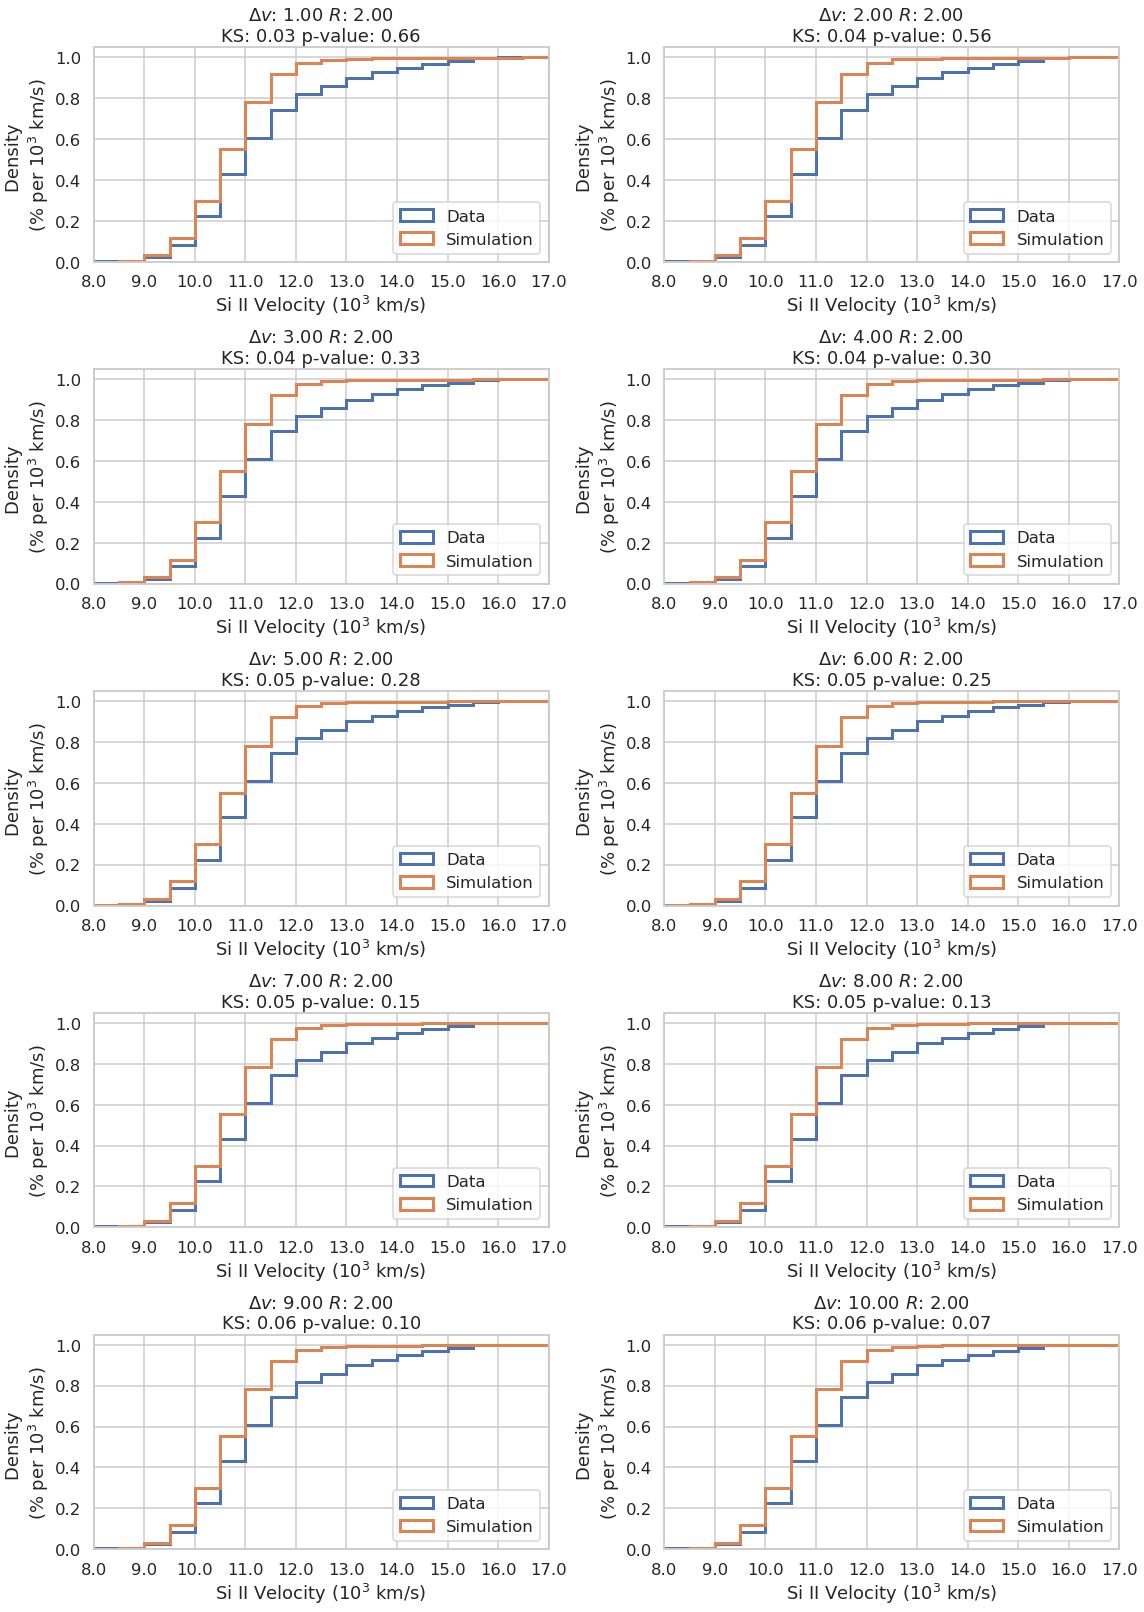

In [22]:
nrows, ncols = 5, 2
fig, axs = plt.subplots(nrows, ncols, figsize=(16, 4.5*nrows))

for i in range(nrows*ncols):
    ax = axs[i//ncols, i%ncols]
    bins = np.arange(8, 17.5, 0.5)
    xrange = np.linspace(bins.min(), bins.max(), 200)
    
    param=params[i]
    
    # Data
    ax.hist(sn_data['v_siII'], bins, cumulative=True, histtype='step', 
            density=True, linewidth=3, label='Data')
    
    # HV Simulation
    # Use HV from simulation and LV from sampling data fit
    hv_samp = hvs[i]
    
    ax.hist(np.append(hv_samp, lv_samp), bins, cumulative=True, histtype='step', 
            density=True, linewidth=3, label="Simulation")
    
    # Plot Config
    ax.set_xlabel('Si II Velocity ($10^3$ km/s)')
    ax.set_ylabel('Density \n(% per $10^3$ km/s)')
    ax.set_title(f"$\Delta v$: {param['delta_v']:.2f} $R$: {param['R']:.2f} \nKS: {ks[i]:.2f} p-value: {pvalues[i]:.2f}")
    ax.set_xticks(bins[::2])
    ax.set_xticklabels([f'{tick:.1f}' for tick in bins[::2]])
    ax.set_xlim(bins.min(), bins.max())
    ax.legend(loc='lower right')
    
plt.tight_layout()
plt.savefig('grid_search_cumulative_results.png', dpi=300, format='png')

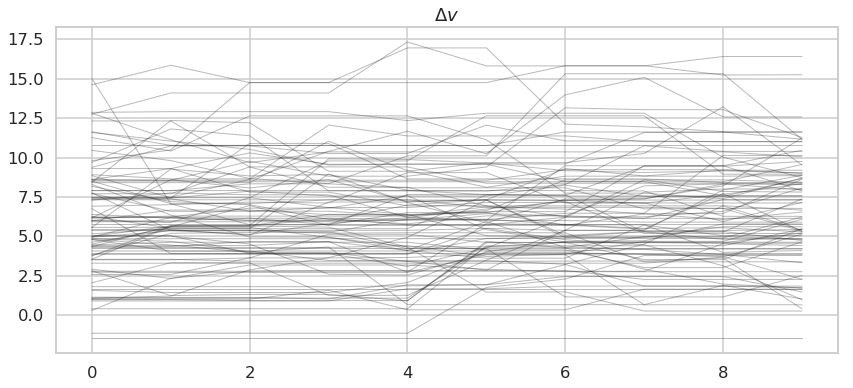

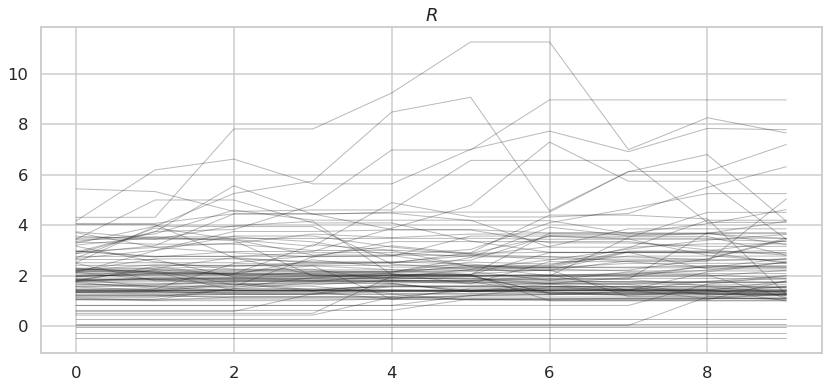

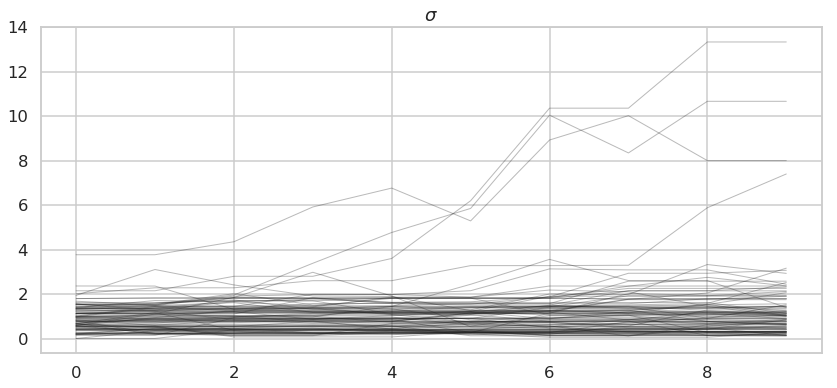

In [10]:
samples = np.load('chain.npy')
labels = ['$\Delta v$', '$R$', '$\sigma$']
for i in range(samples.shape[2]):
    plt.figure(figsize=(14,6))
    for j in range(samples.shape[0]):
        plt.plot(range(samples.shape[1]), samples[j,:,i], color='k', lw=1, alpha=0.3)
    plt.title(labels[i])

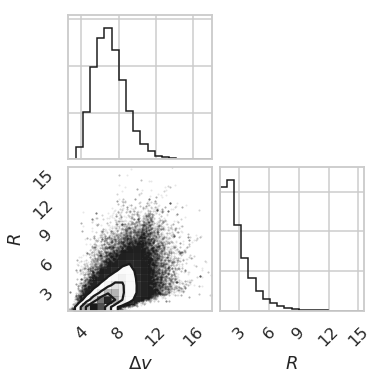

In [23]:
from corner import corner

samples = np.load('chain.npy')
burn_in = 2000
samples = samples[:, burn_in:, :].reshape((-1, samples.shape[2]))
fig = corner(samples[:,:2], labels=["$\Delta v$", "$R$"])

# Results

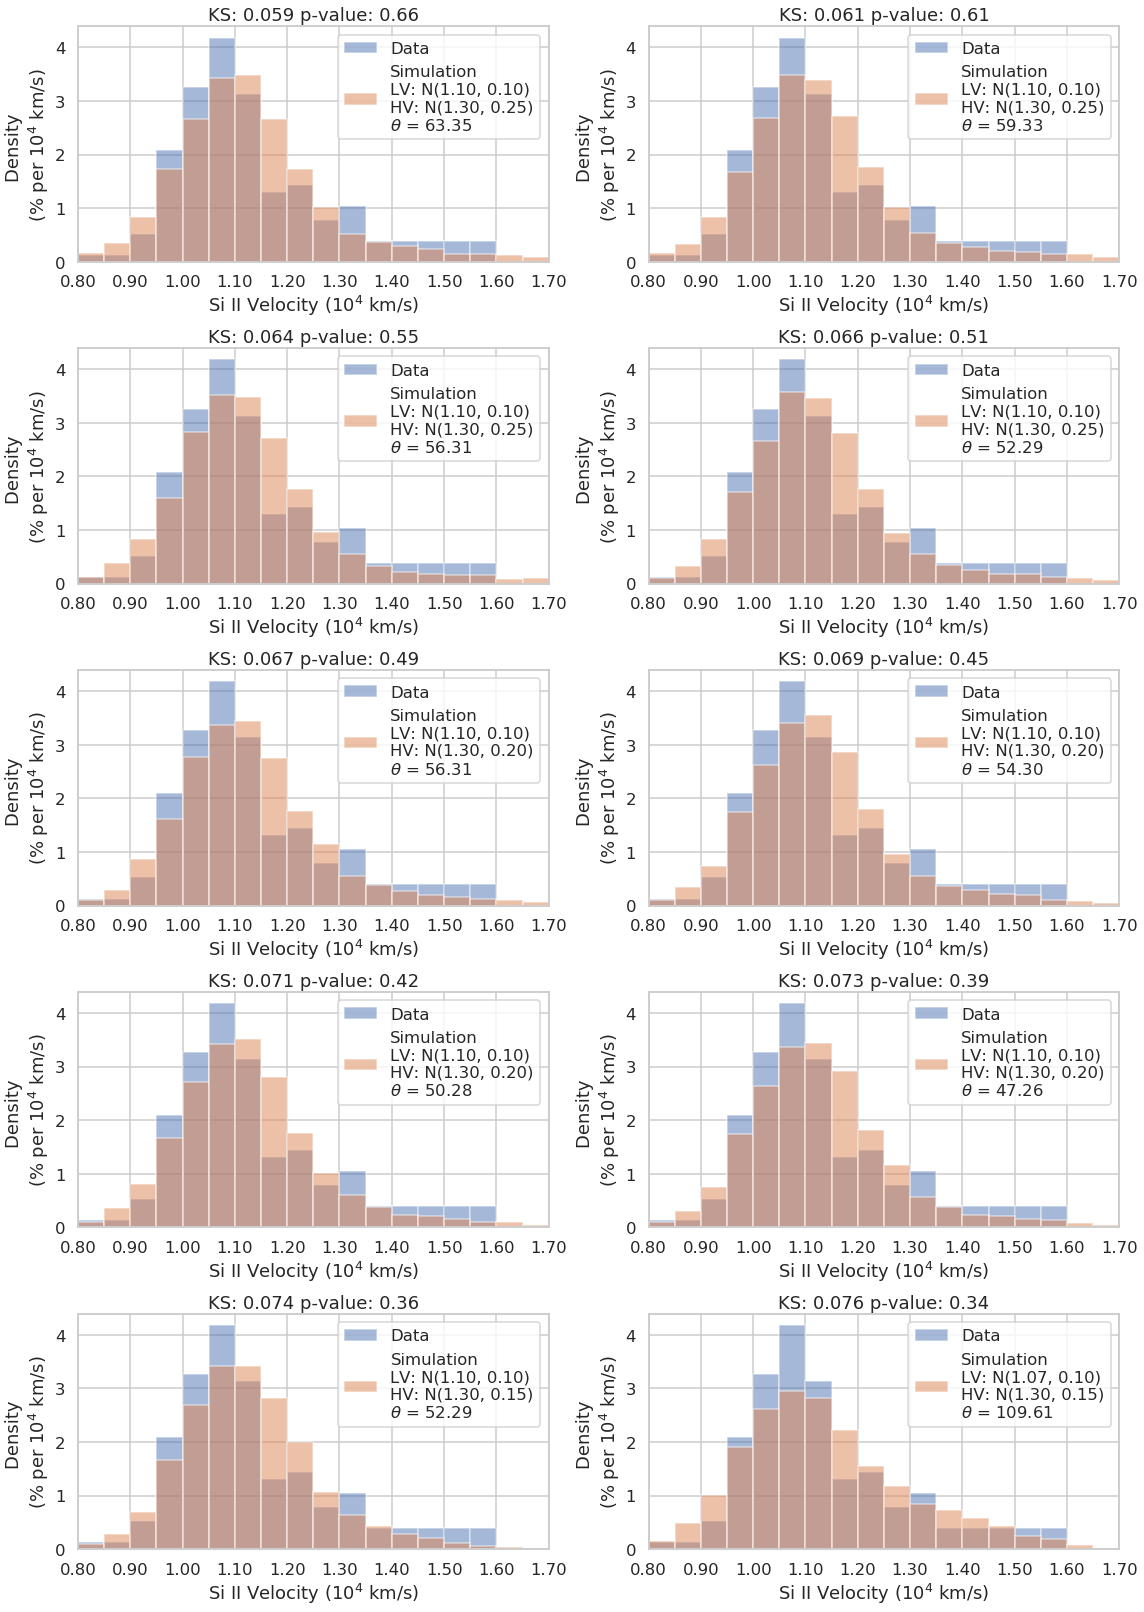

In [25]:
import pickle as pkl

with open('scores.pkl.bak', 'rb') as f:
    scores = pkl.load(f)

sort_idx = np.argsort(scores['ks'])
ks = scores['ks'][sort_idx]
pvalue = scores['pvalue'][sort_idx]
vs = scores['vs'][sort_idx]
params = scores['params'][sort_idx]

nrows, ncols = 5, 2
fig, axs = plt.subplots(nrows, ncols, figsize=(16, 4.5*nrows))

for i in range(nrows*ncols):
    best_vs = vs[i]
    best_ks = ks[i]
    best_pvalue = pvalue[i]
    best_params = params[i]
    mu_LV, sigma_LV = best_params['mu_LV'], best_params['sigma_LV']
    mu_HV, sigma_HV = best_params['mu_HV'], best_params['sigma_HV']
    theta = best_params['theta']
    
    ax = axs[i//ncols, i%ncols]
    bins = np.arange(0.8, 1.75, 0.05)
    ax.hist(sn_data['v_siII'], bins, density=True, alpha=0.5, label='Data')
    ax.hist(best_vs, bins, density=True, alpha=0.5, 
            label=(
                f'Simulation\n' + 
                f'LV: N({mu_LV:.2f}, {sigma_LV:.2f})\n' + 
                f'HV: N({mu_HV:.2f}, {sigma_HV:.2f})\n' + 
                fr'$\theta$ = {theta:.2f}'
            )
           )
    ax.set_xlabel('Si II Velocity ($10^3$ km/s)')
    ax.set_ylabel('Density \n(% per $10^3$ km/s)')
    ax.set_title(f"KS: {best_ks:.3f} p-value: {best_pvalue:.2f}")
    ax.set_xticks(bins[::2])
    ax.set_xticklabels([f'{tick:.2f}' for tick in bins[::2]])
    ax.set_xlim(bins.min(), bins.max())
    ax.legend()
plt.tight_layout()

Plotted above is the velocity distribution of the top 10 KS scoring parameters. Notice all the parameters for the first 9 simulations are similar with varying spread $\theta$ ranging from about [45, 65] degrees. The last simulation plotted however greatly differs in $\theta$. This suggest a possible degeneracy in the best estimated $\theta$ parameter. 

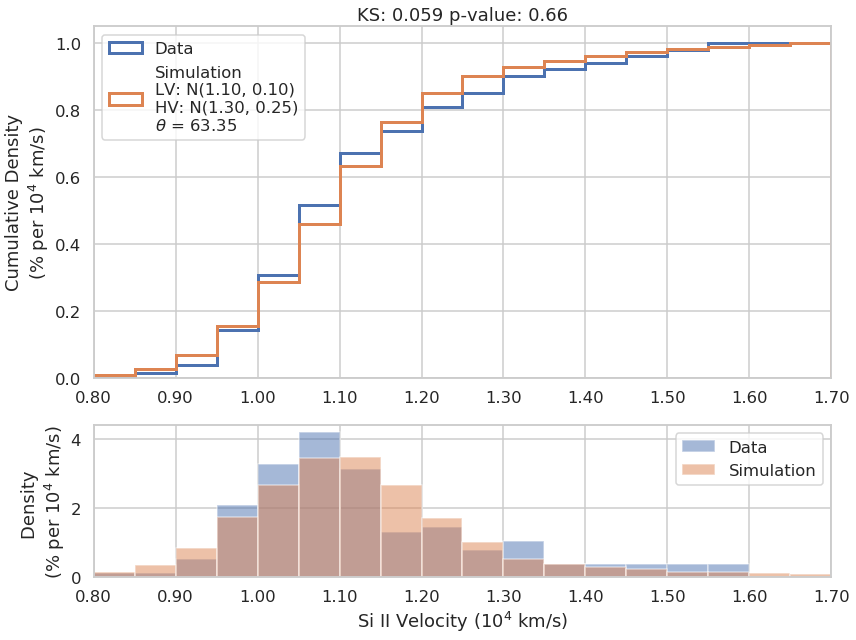

In [26]:
i = 0
best_vs = vs[i]
best_ks = ks[i]
best_pvalue = pvalue[i]
best_params = params[i]
mu_LV, sigma_LV = best_params['mu_LV'], best_params['sigma_LV']
mu_HV, sigma_HV = best_params['mu_HV'], best_params['sigma_HV']
theta = best_params['theta']

plt.figure(figsize=(12, 9))
ax2 = plt.subplot2grid((3,1), (2,0))
ax1 = plt.subplot2grid((3,1), (0,0), rowspan=2, sharex=ax2)

bins = np.arange(0.8, 1.75, 0.05)
ax2.hist(sn_data['v_siII'], bins, density=True,
         alpha=0.5, label='Data')
ax2.hist(best_vs, bins, density=True, 
         alpha=0.5, label=f'Simulation')
ax2.set_xlabel('Si II Velocity ($10^3$ km/s)')
ax2.set_ylabel('Density \n(% per $10^3$ km/s)')


ax1.hist(sn_data['v_siII'], bins, cumulative=True, histtype='step', 
        density=True, linewidth=3, label='Data')
ax1.hist(best_vs, bins, cumulative=True, histtype='step', 
        density=True, linewidth=3, label=(
            f'Simulation\n' + 
            f'LV: N({mu_LV:.2f}, {sigma_LV:.2f})\n' + 
            f'HV: N({mu_HV:.2f}, {sigma_HV:.2f})\n' + 
            fr'$\theta$ = {theta:.2f}'))
ax1.set_ylabel('Cumulative Density\n(% per $10^3$ km/s)')
ax1.set_title(f'KS: {best_ks:.3f} p-value: {best_pvalue:.2f}')

# Plot config
ax1.legend(loc='upper left')

ax2.set_xticks(bins[::2])
ax2.set_xticklabels([f'{tick:.2f}' for tick in bins[::2]])
ax2.set_xlim(bins.min(), bins.max())
ax2.legend()

plt.tight_layout()
plt.savefig('best.png', dpi=300, format='png')

Plotted above is the top KS scoring simulation. The bottom plot is the same plot as the previous figure. The top plot is the cumulative distirbution of the bottom.

# Discussion

The distinction in Si II velocity distribution may be described by asymmetries in SNe Ia's ejecta. We produced a two-dimensional simulation under the assumption that the ejecta asymmetries is only angular (i.e., the ejecta is anisotropic) where the there exist a angular region on the photospheric shell that has a velocity higher than the remaining shell. These two region are labeled as high-velocity ejecta (HV) and low-velocity ejecta (LV). We assume for a given SN Ia, its ejecta velocity of the HV and LV region are of a single value sampled from two normal distributions. The best performing simulations resulted in reasonable and consistent values of the normal distribution's mean and standard deviatons. However, the parameter describing the angular spread of the HV ejecta region varies a lot. Further constraints are required to gather any intuitive conclusion to whether or not the simulation does represent the data. These constraints should come from empirical evidence and existing SNe Ia models.

# References

Hillebrandt, W., & Niemeyer, J. C. 2000, ARA&A, 38, 191

Levanon, N., & Soker, N. 2019, arXiv:1901.05057

Polin, A., Nugent, P. E., & Kasen, D. 2019, ApJ, 873, 1

Silverman, J. M., Kong, J. J., Filippenko, A. V., et al., 2012, MNRAS, 425, 1819

Wang, X., Wang, L., & Filippenko, A. V.  2013, Science, 340, 6129

Zheng, W., Kelly, P. L., & Filippenko, A. V. 2018, ApJ, 858, 104

# Appendix

## Grid Search

```python
import time
import numpy as np
import pickle as pkl
from scipy.stats import norm, ks_2samp
from sklearn.model_selection import ParameterGrid
from dataloader import import_sn_data

param_grid = {
    'theta': np.linspace(0, 180, 180),
    'mu_HV': np.linspace(1.3, 5, 10),
    'sigma_HV': np.linspace(0.1, 0.3, 5),
    'mu_LV': np.linspace(1., 1.3, 10),
    'sigma_LV': np.linspace(0.1, 0.5, 5),
}

def model_vdist(theta, mu_HV, sigma_HV, mu_LV, sigma_LV, sample_size=1000):
    los = np.random.uniform(-180, 180, sample_size)

    cond = (los > -theta/2) & (los < theta/2)
    hv_size = np.sum(cond)
    lv_size = np.sum(~cond)

    vs = np.append(
        np.random.normal(mu_HV, sigma_HV, hv_size),
        np.random.normal(mu_LV, sigma_LV, lv_size)
    )
    return vs


def simulate_grid(vs_data, param_grid, **kwargs):
    param_grid = ParameterGrid(param_grid)
    scores = {
        'vs': [],
        'ks': [],
        'pvalue': [],
        'params': []
    }

    nparams = len(param_grid)
    start = time.perf_counter()
    elapsed_times = []
    for i, params in enumerate(param_grid):
        vs = model_vdist(**params, **kwargs)
        ks, pvalue = ks_2samp(vs_data, vs)

        if i < 100:
            scores['vs'].append(vs)
            scores['ks'].append(ks)
            scores['pvalue'].append(pvalue)
            scores['params'].append(params)
        else:
            max_idx = np.argmax(scores['ks'])
            if ks < scores['ks'][max_idx]:
                scores['vs'][max_idx]= vs
                scores['ks'][max_idx]= ks
                scores['pvalue'][max_idx]= pvalue
                scores['params'][max_idx]= params

        if (i != 0) and (i % (nparams / 100) == 0):
            end = time.perf_counter()
            elapsed_times.append(end-start)
            mean_step_period = np.mean(elapsed_times) / (nparams / 100)
            print(f"Step [{i}/{nparams}] ", end='')
            print(
                # f"{params} " +
                f"KS: {ks:.3f} " +
                f"p-value: {pvalue:.2f} " +
                f"Elapsed Time: {elapsed_times[-1]:.2f} secs " +
                f"ETA: {(nparams - i) * mean_step_period / 60:.2f} mins "
            )
            start = time.perf_counter()

    return {k: np.array(v) for k, v in scores.items()}


if __name__ == "__main__":
    sn_data = import_sn_data()
    scores = simulate_grid(sn_data['v_siII'], param_grid, sample_size=10000)
    print(scores)

    # ks = scores['ks']
    # sort_idx = np.argsort(ks)
    # ks = ks[sort_idx]
    # vs = scores['vs'][sort_idx]
    # params = scores['params'][sort_idx]

    with open('scores.pkl', 'wb') as f:
        # pkl.dump({k: v[:10] for k, v in scores.items()}, f)
        pkl.dump(scores, f)
```